# This file is used to analyze real experiment data collected in December of 2022 + Simulation data






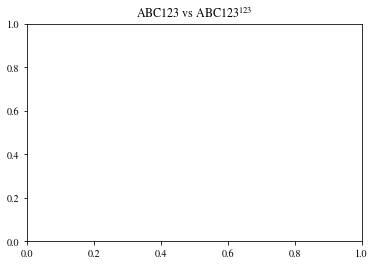

In [1]:
import pandas as pd
import numpy as np
import sys
import copy

import matplotlib.pyplot as plt
%matplotlib inline
# To change the default font like latex font
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')
import matplotlib as mpl

import itertools
import scipy.stats as stats

# Selecting colors
import seaborn as sns

palette_tab20 = sns.color_palette("tab20", 20)

In [2]:
def countCommas(s):
    try:
        return s.count(',')
    except:
        return np.nan

# Content

- [Data Import](#Data-Import)
- [Define functions and important variables](#Define-functions-and-important-variables)
- [Start Data Analysis](#Start-Data-Analysis)


# Data Import

-[Return](#Content)

In [3]:
data_ABA= pd.read_csv('..\\ProcessedData\\data_ABA.csv')
data_BAB=pd.read_csv('..\\ProcessedData\\data_BAB.csv')

In [4]:
# Data with opportunity 
data_Oppor_B1 = pd.read_csv('..\\ProcessedData\\data_Oppor_B1.csv')
data_Oppor_allB = pd.read_csv('..\\ProcessedData\\data_Oppor_allB.csv')

In [5]:
# Data local only 
data_noOppor_AllA = pd.read_csv('..\\ProcessedData\\data_noOppor_AllA.csv')
data_noOppor_A2=pd.read_csv('..\\ProcessedData\\data_noOppor_A2.csv')

# Start Data Analysis

Sequence : [7, 6, 18, 17, 13, 8, 12, 7]

A1 = [7] (10 rounds)

B1 = [6,18,17]

A2 = [13]

B2 = [8]

-[Local Only Environment ](#Local-Only-Environment )

-[Local + Global Environment](#Local-+-Global-Environment)

-[For simulation (Local Only)](#For-simulation-(Local-Only))

-[For simulation (Local + Global)](#For-simulation-(Local-+-Global))

-[Welfare Counterfactual](#Welfare-Counterfactual)

-[Return](#Content)


# Define functions and important variables 

-[Return](#Content)


In [6]:
def bootstrap_ci(data, n_samples, stat):
    
    n = len(data)                                #get length of the data
    ix = np.random.randint(0, n, (n_samples, n)) #get an array of bootsrapped indices
    samples = data[ix]                           #create bootrapped samples
    
    distribution = stat(samples, axis=1)

    return (np.percentile(distribution,2.5),np.percentile(distribution,97.5))

In [7]:
def permutation_test_r(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    original_stat=np.mean(sample1)-np.mean(sample2)
    print("Original Statistic:",original_stat)
    combined=np.append(sample1,sample2)
    #print combined
    permutations=np.matrix(list(itertools.permutations(combined)))
    print(permutations)
    n_permut=len(permutations)
    print("Number of permutations:",len(permutations))
    distr=permutations[:,0:n1].mean(axis=1)-permutations[:,n1:n1+n2].mean(axis=1)
    count=(distr<=original_stat).sum()
    print("Count: ",count," out of ",n_permut)
    p_val=np.round(float(count)/float(n_permut),3)
    print("Probability: ",p_val)

In [8]:
def permutation_test(pop_a, pop_b):

    original_statistics = pop_a.mean() - pop_b.mean()
    print(original_statistics)

    print('# 2. use permutation test (non-parametric test)' )
    n1 = len(pop_a)
    n2 = len(pop_b)
    
    sim_num = 10000
    
    combined = np.append(pop_a, pop_b)
#     permutationss=np.matrix(list(permutations(combined)))
#     n_permut=len(permutationss)
    n = len(combined)
    idx = np.arange(n)
    sim_d = []
    for i in range(sim_num):
        np.random.shuffle(idx)
        d = np.mean(combined[idx][0:n1]) - np.mean(combined[idx][n1::])
    #     print(d)
        sim_d.append(d)
    # calculate the p-value for two-sided test:
    count = (np.abs(sim_d)>=np.abs(original_statistics)).sum()
    # calculate the one-sided test, first-second
#     count = (np.array(sim_d)>=original_statistics).sum()
#     print(count)
    p_val = np.round((count+1)/(sim_num+1), 3)
    print("p-value for two-sided test", p_val)
    
#     distr=np.array(np.ma.mean(permutationss[:,0:n1],1)-np.ma.mean(permutationss[:,n1:n1+n2],1))
# #     count=(distr<=original_statistics).sum()
#     count=(np.abs(distr)>=np.abs(original_statistics)).sum()
#     print("Permutation Count: ",count," out of ",n_permut)
#     p_val=np.round(float(count)/float(n_permut),3)
#     print("two-sided Probability: ",p_val)


In [9]:
def CreateMean_CI_byHypothese(data, var, treatment_var, treatment_list, totalR):
    all_data = data
    # Create a matrix for 3 outputs: mean, upper CI, lower CI
    # The size is #Rounds * #Treatments
    output = np.empty((3, totalR, len(treatment_list)))
    output[:]=np.nan
    
    for i,t in enumerate(treatment_list): # Fixed the treatment order
        for r in range(1,totalR+1):
            pop_a = all_data.loc[(all_data[treatment_var]==t) & (all_data['subsession.period']==r), var]

            if not pop_a.empty :
                output[0,r-1,i] = pop_a.mean()
                output[1,r-1,i],output[2,r-1,i] = bootstrap_ci(np.array(pop_a), 10000, np.mean)
            else : 
                pass
    return output

In [10]:
def calculate_MDR(data1, data2,var, T_l, T_h):
    Data_mean = data1[(data1['subsession.period']>=T_l)&(data1['subsession.period']<=T_h)].groupby(['Treatment_4'])[var].mean()
    Sim_mean = data2[(data2['subsession.period']<=T_h)&(data2['subsession.period']>=T_l)].groupby(['Treatment_4'])[var].mean()
    return np.square(Data_mean - Sim_mean).sum()/len(Sim_mean)



# For simulation (Local Only)

-Return : [Start Data Analysis](#Start-Data-Analysis)


In [168]:
#To easily input different files:
# Imported the counterfactual data
# outputFolder = "..\\..\\Model\\SimulatedResults\\SimOutput\\"
outputFolder = 'D:\\IEL_PGCL\\'
# filename = 'BAB_Replicate.csv'

# filename = '19_sensitivity_long_BABp_0.48_b_22_g_8.csv.csv'

# filename = '19-sensitivity-BABp_0.48_b_40_g_0.csv.csv'
# filename = '19-sensitivity-BABp_0.48_b_0_g_15.csv.csv'

# filename = '19-sensitivity-BABp_0.48_b_22_g_15.csv.csv'
# filename = '19-sensitivity-BABp_0.48_b_40_g_15.csv.csv'

# filename = 'BABp_0_b_22_g_8.csv'
# filename = 'BABp_1_b_22_g_8.csv'

# filename = '19-sensitivity-BABp_0.48_b_22_g_8.csv.csv' # to make sure the file can replicate the fit graphs
# outputfigurel = '..\\Output\\06-group-data-Dec-2022-Add-Simulation-All-L.pdf'
# outputfigure1 = '..\\Output\\06-group-data-Dec-2022-Add-Simulation-All-LG-join.pdf'
# outputfigure2 = '..\\Output\\06-group-data-Dec-2022-Add-Simulation-All-LG-tradeoff.pdf'

# filename = '19-sensitivity-BABp_0.48_b_40_g_0.csv.csv'
# outputfigure = '..\\Output\\06-group-data-Dec-2022-Add-Simulation-Sensitivity-B40-G0.pdf'

# filename = '19-sensitivity-BABp_0.48_b_60_g_0.csv'
# outputfigurel = '..\\Output\\06-group-data-Dec-2022-Add-Simulation-B60_G0-L.pdf'
# outputfigure1 = '..\\Output\\06-group-data-Dec-2022-Add-Simulation-B60_G0-LG-join.pdf'
# outputfigure2 = '..\\Output\\06-group-data-Dec-2022-Add-Simulation-B60_G0-LG-tradeoff.pdf'

# filename = '19-sensitivity-BABp_0.48_b_0_g_15.csv.csv'
# outputfigurel = '..\\Output\\06-group-data-Dec-2022-Add-Simulation-B0_G15-L.pdf'
# outputfigure1 = '..\\Output\\06-group-data-Dec-2022-Add-Simulation-B0_G15-LG-join.pdf'
# outputfigure2 = '..\\Output\\06-group-data-Dec-2022-Add-Simulation-B0_G15-LG-tradeoff.pdf'

# filename = '19-sensitivity-BABp_0.48_b_0_g_15.csv.csv'
# outputfigure = '..\\Output\\06-group-data-Dec-2022-Add-Simulation-Sensitivity-B0-G15.pdf'

filename = '19-sensitivity-BABp_0.48_b_40_g_8.csv.csv'
# outputfigure = '..\\Output\\06-group-data-Dec-2022-Add-Simulation-Sensitivity-B40-G8.pdf'
outputfigurel = '..\\Output\\06-group-data-Dec-2022-Add-Simulation-B40_G8-L.pdf'
outputfigure1 = '..\\Output\\06-group-data-Dec-2022-Add-Simulation-B40_G8-LG-join.pdf'
outputfigure2 = '..\\Output\\06-group-data-Dec-2022-Add-Simulation-B40_G8-LG-tradeoff.pdf'


# filename = '19-sensitivity-BABp_0.48_b_40_g_5.csv.csv'
# outputfigure = '..\\Output\\06-group-data-Dec-2022-Add-Simulation-Sensitivity-B40-G5.pdf'

# filename = '19-sensitivity-BABp_0.48_b_40_g_15.csv.csv'
# outputfigure = '..\\Output\\06-group-data-Dec-2022-Add-Simulation-Sensitivity-B40-G15.pdf'

# filename = '19-sensitivity-BABp_0.48_b_22_g_15.csv.csv'
# outputfigure = '..\\Output\\06-group-data-Dec-2022-Add-Simulation-Sensitivity-B22-G15.pdf'

# filename = '19-sensitivity-BABp_0.48_b_30_g_5.csv.csv'
# outputfigure = '..\\Output\\06-group-data-Dec-2022-Add-Simulation-Sensitivity-B30-G5.pdf'

# filename = '19-sensitivity-BABp_0.48_b_30_g_8.csv.csv'
# outputfigure = '..\\Output\\06-group-data-Dec-2022-Add-Simulation-Sensitivity-B30-G8.pdf'

# filename = '19_sensitivity_long_BABp_0.48_b_22_g_8.csv.csv'

# filename = '19-BAB-equalweight-p_0.48_b_22_g_8.csv'
# outputfigure1 = '..\\Output\\06-group-data-Dec-2022-Add-Simulation-Sensitivity-equalWeight-join.pdf'
# outputfigure2 = '..\\Output\\06-group-data-Dec-2022-Add-Simulation-Sensitivity-equalWeight-tradeoff.pdf'

CounterfactualData = pd.read_csv(outputFolder+filename)
CounterfactualData = CounterfactualData[(CounterfactualData['FC']==20) | (CounterfactualData['FC']==80)]
CounterfactualData = CounterfactualData.rename(columns={"endow_org": "endowment", "session_num":"session.code"})

In [169]:
data_OpporSim['subsession.round_number'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
      dtype=int64)

# For the long sequence


In [170]:
# data_OpporSim = CounterfactualData[CounterfactualData['Sequence']=='B1_bab']
# data_OpporSim['End_level'] = "Homo (20)" 
# data_OpporSim.loc[data_OpporSim['endowment']<=10,'End_level'] = "Low (10)"
# data_OpporSim.loc[data_OpporSim['endowment']>20,'End_level'] = "High (30)"

# data_OpporSim['tot_contr'] = data_OpporSim['player.contribution_local'] + np.nan_to_num(data_OpporSim['player.contribution_global'])
# data_OpporSim['tot_cont_share'] = data_OpporSim['tot_contr'] / data_OpporSim['endowment'] * 100
# data_OpporSim['T_endw_comp']= data_OpporSim['Treatment'] + ', ' + data_OpporSim['End_level']
# data_OpporSim['local_share'] = data_OpporSim['player.contribution_local']/ data_OpporSim['endowment'] * 100
# data_OpporSim['global_share'] = data_OpporSim['player.contribution_global']/ data_OpporSim['endowment'] * 100
# data_OpporSim[ 'player.join_club'] = 1- np.isnan(data_OpporSim['player.contribution_global'])


# data_OpporSim['Treatment_4']= 'Homogeneous\nLowC'
# data_OpporSim.loc[(data_OpporSim['Treatment']=='HOMO') & (data_OpporSim['FC']==80),'Treatment_4'] = "Homogeneous\nHighC"
# data_OpporSim.loc[(data_OpporSim['Treatment']=='HETERO') & (data_OpporSim['FC']==20),'Treatment_4'] = "Heterogeneous\nLowC"
# data_OpporSim.loc[(data_OpporSim['Treatment']=='HETERO') & (data_OpporSim['FC']==80),'Treatment_4'] = "Heterogeneous\nHighC"

In [171]:
# treatment_list = ['HOMO', 'HETERO']
# treatment_var = 'Treatment_4'
# var_of_interest =  'player.join_club'
# LocalOnly = data_OpporSim.groupby([ 
#                       treatment_var,
#     'player.local_community', 
# #     'session.code',
#                       'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()
# # LocalOnly[LocalOnly['Treatment_4']=='Heterogeneous\nHighC']
# LocalOnly[LocalOnly['Treatment_4']=='Heterogeneous\nHighC']

In [172]:
# ### This is to create the graph for all rounds (colored)
# data_Oppor=data_OpporSim
# data_Oppor = data_Oppor.drop(columns=['subsession.period'])
# data_Oppor['subsession.period'] = data_Oppor['subsession.round_number'] 


# treatment_list = ['HOMO', 'HETERO']
# treatment_var = 'Treatment'
# var_of_interest =  'player.join_club'
# GroupedData = data_Oppor.groupby([ 
#                       treatment_var,
#     'player.local_community',  'session.code',
#                       'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

# # Left graph for FC=2
# output = CreateMean_CI_byHypothese(GroupedData[GroupedData['FC']==20], 
#                                    var_of_interest,treatment_var,treatment_list , 20)

# df_LGs1 = pd.DataFrame(output[0,:,:], columns = treatment_list)
# df_LGs1_ci_l = pd.DataFrame(output[1,:,:], columns = treatment_list)
# df_LGs1_ci_u = pd.DataFrame(output[2,:,:], columns = treatment_list)

# # right graph for absolute value 

# output = CreateMean_CI_byHypothese(GroupedData[GroupedData['FC']==80], var_of_interest,treatment_var,treatment_list , 50)

# df_LGs1_r = pd.DataFrame(output[0,:,:], columns = treatment_list)
# df_LGs1_ci_lr = pd.DataFrame(output[1,:,:], columns = treatment_list)
# df_LGs1_ci_ur = pd.DataFrame(output[2,:,:], columns = treatment_list)


#  # Join Behavior
# treatment_list = ['HOMO', 'HETERO']
# treatment_var = 'Treatment'
# var_of_interest =  'player.join_club'
# LocalOnly = data_OpporSim.groupby([ 
#                       treatment_var,
#     'player.local_community',   'session.code',
#                       'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

# # Left graph for FC=2
# output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], 
#                                    var_of_interest,treatment_var,treatment_list , 50)

# df_LGs1Simj = pd.DataFrame(output[0,:,:], columns = treatment_list)
# df_LGs1_ci_lSimj = pd.DataFrame(output[1,:,:], columns = treatment_list)
# df_LGs1_ci_uSimj = pd.DataFrame(output[2,:,:], columns = treatment_list)

# # right graph for absolute value 

# output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_of_interest,treatment_var,treatment_list , 50)

# df_LGs1_rSimj = pd.DataFrame(output[0,:,:], columns = treatment_list)
# df_LGs1_ci_lrSimj = pd.DataFrame(output[1,:,:], columns = treatment_list)
# df_LGs1_ci_urSimj = pd.DataFrame(output[2,:,:], columns = treatment_list)

# pd.set_option('plotting.backend', 'matplotlib')


In [173]:



# fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  sharey=True,  
#                          constrained_layout=True, figsize=(40, 20))
# fig.set_constrained_layout_pads( w_pad=1 / 100)

# # Left figure
# # Defining custom 'xlim' and 'ylim' values.
# custom_xlim = (0, 81)
# custom_ylim = (0, 1.1)
# custom_ytick = np.arange(0,1.1,step=.2)
# custom_xticklabel = np.arange(1,81,step=5)
# # [1,5,10,15,20]

# plt.setp(axes[0], 
#      yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','*', 'o', '*', '*', '*']
    
# custom_markercolor = ['black','black', 'black', ]
# custom_markerfacecolor = ['white', 'white','black']
# custom_linestyle = [':','-']
# labels =  ['Homogeneous\nLowC', 'Heterogeneous\nLowC', 'Homogeneous\nHighC', 'Heterogeneous\nHighC']

# for j, yy in enumerate(treatment_list):
#     # Simulation 
#     axes[0].plot(df_LGs1Simj[yy], label=labels[j+2], marker=custom_marker[j], c='red', 
#                          ls=custom_linestyle[j],markerfacecolor='red',
#                          linewidth=10,  markersize=30 )

    
# axes[0].set_xlabel('Round', fontsize=70)
# axes[1].set_xlabel('Round', fontsize=70)
# axes[0].set_ylabel('Average club size ', fontsize=70)
# axes[0].set_title('LowC', fontsize=70)


# # Right figure
# # Defining custom 'xlim' and 'ylim' values.
# plt.setp(axes[1],
#      yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)


# for j, yy in enumerate(treatment_list):
#     # Simulation 
#     axes[1].plot(df_LGs1_rSimj[yy], label=labels[j+2], marker=custom_marker[j], c='red', 
#                          ls=custom_linestyle[j],markerfacecolor='red',
#                          linewidth=10,  markersize=30 )

# axes[1].set_title('HighC', fontsize=70)

# for i in range(2):
#     axes[i].spines['top'].set_visible(False)
#     axes[i].spines['right'].set_visible(False)  
#     axes[i].tick_params(axis='x', labelsize=70)
#     axes[i].tick_params(axis='y', labelsize=70)

# # handles, labels = axes[0].get_legend_handles_labels() 

# fig.legend(bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=70,
#                borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
# # fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Global-Join.pdf_LGs1', bbox_inches="tight" )  


# To calculate fit

In [174]:
# # Data:

# #ENvironment L
# data_noOppor = data_noOppor_AllA
# data_noOppor['End_level'] = "High (30)"
# data_noOppor.loc[data_noOppor['endowment']==10,'End_level'] = "Low (10)"
# data_noOppor.loc[data_noOppor['endowment']==20,'End_level'] = "Homo (20)"
# data_noOppor['tot_cont_share'] = data_noOppor['tot_contr'] / data_noOppor['endowment'] * 100
# data_noOppor['T_endw_comp']= data_noOppor['Treatment'] + ', ' + data_noOppor['End_level']
# data_noOppor['Treatment_4']= 'Homogeneous\nLowC'
# data_noOppor.loc[(data_noOppor['Treatment']=='HOMO') & (data_noOppor['FC']==80),'Treatment_4'] = "Homogeneous\nHighC"
# data_noOppor.loc[(data_noOppor['Treatment']=='HETERO') & (data_noOppor['FC']==20),'Treatment_4'] = "Heterogeneous\nLowC"
# data_noOppor.loc[(data_noOppor['Treatment']=='HETERO') & (data_noOppor['FC']==80),'Treatment_4'] = "Heterogeneous\nHighC"


# # Environment LG

# data_Oppor = data_Oppor_allB
# data_Oppor['End_level'] = "Homo (20)" 
# data_Oppor.loc[data_Oppor['endowment']<=10,'End_level'] = "Low (10)"
# data_Oppor.loc[data_Oppor['endowment']>20,'End_level'] = "High (30)"
# data_Oppor['tot_cont_share'] = data_Oppor['tot_contr'] / data_Oppor['endowment'] * 100
# data_Oppor['T_endw_comp']= data_Oppor['Treatment'] + ', ' + data_Oppor['End_level']
# data_Oppor['local_share'] = data_Oppor['player.contribution_local']/ data_Oppor['endowment'] * 100
# data_Oppor['global_share'] = data_Oppor['player.contribution_global']/ data_Oppor['endowment'] * 100
# data_Oppor['Treatment_4']= 'Homogeneous\nLowC'
# data_Oppor.loc[(data_Oppor['Treatment']=='HOMO') & (data_Oppor['FC']==80),'Treatment_4'] = "Homogeneous\nHighC"
# data_Oppor.loc[(data_Oppor['Treatment']=='HETERO') & (data_Oppor['FC']==20),'Treatment_4'] = "Heterogeneous\nLowC"
# data_Oppor.loc[(data_Oppor['Treatment']=='HETERO') & (data_Oppor['FC']==80),'Treatment_4'] = "Heterogeneous\nHighC"


In [175]:
# NMSE = np.zeros((7,8))
# outputFolder = 'D:\\IEL_PGCL\\'
# for i,b in enumerate([0,10,22,30,40,50,60]) :
#     for j,g in enumerate([0,5,8,10,15,20,30,40]):
        

#         filename = '19-sensitivity-BABp_0.48_b_'+str(b)+'_g_'+str(g)+'.csv.csv'
#         if filename in os.listdir('D:\\IEL_PGCL\\'):
#             CounterfactualData = pd.read_csv(outputFolder+filename)
#         else :
#             filename = '19-sensitivity-BABp_0.48_b_'+str(b)+'_g_'+str(g)+'.csv'
#             if filename in os.listdir('D:\\IEL_PGCL\\'):
#                 CounterfactualData = pd.read_csv(outputFolder+filename)
#         CounterfactualData = CounterfactualData[(CounterfactualData['FC']==20) | (CounterfactualData['FC']==80)]
#         CounterfactualData = CounterfactualData.rename(columns={"endow_org": "endowment", "session_num":"session.code"})

#         # Environment L: 
#         data_noOppor_sim = CounterfactualData[CounterfactualData['Sequence']=='A2_bab']
#         data_noOppor_sim['tot_contr'] = data_noOppor_sim['player.contribution_local']
#         data_noOppor_sim['tot_cont_share'] = data_noOppor_sim['tot_contr'] / data_noOppor_sim['endowment'] * 100
#         data_noOppor_sim['Treatment_4']= 'Homogeneous\nLowC'
#         data_noOppor_sim.loc[(data_noOppor_sim['Treatment']=='HOMO') & (data_noOppor_sim['FC']==80),'Treatment_4'] = "Homogeneous\nHighC"
#         data_noOppor_sim.loc[(data_noOppor_sim['Treatment']=='HETERO') & (data_noOppor_sim['FC']==20),'Treatment_4'] = "Heterogeneous\nLowC"
#         data_noOppor_sim.loc[(data_noOppor_sim['Treatment']=='HETERO') & (data_noOppor_sim['FC']==80),'Treatment_4'] = "Heterogeneous\nHighC"


#         # Environment LG:
#         data_OpporSim = CounterfactualData[CounterfactualData['Sequence']=='B1_bab']
#         data_OpporSim['End_level'] = "Homo (20)" 
#         data_OpporSim.loc[data_OpporSim['endowment']<=10,'End_level'] = "Low (10)"
#         data_OpporSim.loc[data_OpporSim['endowment']>20,'End_level'] = "High (30)"

#         data_OpporSim['tot_contr'] = data_OpporSim['player.contribution_local'] + np.nan_to_num(data_OpporSim['player.contribution_global'])
#         data_OpporSim['tot_cont_share'] = data_OpporSim['tot_contr'] / data_OpporSim['endowment'] * 100
#         data_OpporSim['T_endw_comp']= data_OpporSim['Treatment'] + ', ' + data_OpporSim['End_level']
#         data_OpporSim['local_share'] = data_OpporSim['player.contribution_local']/ data_OpporSim['endowment'] * 100
#         data_OpporSim['global_share'] = data_OpporSim['player.contribution_global']/ data_OpporSim['endowment'] * 100
#         data_OpporSim[ 'player.join_club'] = 1- np.isnan(data_OpporSim['player.contribution_global'])


#         data_OpporSim['Treatment_4']= 'Homogeneous\nLowC'
#         data_OpporSim.loc[(data_OpporSim['Treatment']=='HOMO') & (data_OpporSim['FC']==80),'Treatment_4'] = "Homogeneous\nHighC"
#         data_OpporSim.loc[(data_OpporSim['Treatment']=='HETERO') & (data_OpporSim['FC']==20),'Treatment_4'] = "Heterogeneous\nLowC"
#         data_OpporSim.loc[(data_OpporSim['Treatment']=='HETERO') & (data_OpporSim['FC']==80),'Treatment_4'] = "Heterogeneous\nHighC"

#         X =calculate_MDR(data_Oppor, data_OpporSim, 'global_share', 6, 10)  + calculate_MDR(data_Oppor, data_OpporSim, 'local_share', 6, 10)  + calculate_MDR(data_noOppor_sim, data_noOppor,'tot_cont_share', 6,10) 
#         NMSE[i,j] =  np.sqrt(X/3)

In [176]:
# NMSE

In [177]:
# pd.DataFrame(NMSE).to_csv('..\\Output\\NMSE.csv')

# To generate graphs: 

In [178]:
data_noOppor_sim = CounterfactualData[CounterfactualData['Sequence']=='A2_bab']

data_noOppor_sim['tot_contr'] = data_noOppor_sim['player.contribution_local']

data_noOppor_sim['End_level'] = "High (30)"
data_noOppor_sim.loc[data_noOppor_sim['endowment']==10,'End_level'] = "Low (10)"
data_noOppor_sim.loc[data_noOppor_sim['endowment']==20,'End_level'] = "Homo (20)"
data_noOppor_sim['tot_cont_share'] = data_noOppor_sim['tot_contr'] / data_noOppor_sim['endowment'] * 100
data_noOppor_sim['T_endw_comp']= data_noOppor_sim['Treatment'] + ', ' + data_noOppor_sim['End_level']
data_noOppor_sim['Treatment_4']= 'Homogeneous\nLowC'
data_noOppor_sim.loc[(data_noOppor_sim['Treatment']=='HOMO') & (data_noOppor_sim['FC']==80),'Treatment_4'] = "Homogeneous\nHighC"
data_noOppor_sim.loc[(data_noOppor_sim['Treatment']=='HETERO') & (data_noOppor_sim['FC']==20),'Treatment_4'] = "Heterogeneous\nLowC"
data_noOppor_sim.loc[(data_noOppor_sim['Treatment']=='HETERO') & (data_noOppor_sim['FC']==80),'Treatment_4'] = "Heterogeneous\nHighC"


# Left graph 
treatment_list = ['HETERO','HOMO']
treatment_var = 'Treatment'
var_of_interest =  'tot_cont_share'

LocalOnly = data_noOppor_sim.groupby([ treatment_var, 'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

output = CreateMean_CI_byHypothese(LocalOnly, var_of_interest,treatment_var,treatment_list , 20)

dfSim = pd.DataFrame(output[0,:,:], columns = treatment_list)
df_ci_lSim = pd.DataFrame(output[1,:,:], columns = treatment_list)
df_ci_uSim = pd.DataFrame(output[2,:,:], columns = treatment_list)

# right graph
treatment_list_r = ['Homogeneous\nLowC', 'Heterogeneous\nLowC', 'Homogeneous\nHighC', 'Heterogeneous\nHighC']
treatment_var = 'Treatment_4'
var_of_interest =  'tot_cont_share'
LocalOnly = data_noOppor_sim.groupby([  treatment_var, 'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()
output = CreateMean_CI_byHypothese(LocalOnly, var_of_interest,treatment_var,treatment_list_r , 20)

df_rSim = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_lrSim = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_urSim = pd.DataFrame(output[2,:,:], columns = treatment_list_r)

C:\Users\xinxi\AppData\Local\Temp/ipykernel_10068/1707583371.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_noOppor_sim['tot_contr'] = data_noOppor_sim['player.contribution_local']
C:\Users\xinxi\AppData\Local\Temp/ipykernel_10068/1707583371.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_noOppor_sim['End_level'] = "High (30)"
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [179]:
# ### This is to create the graph for all rounds
# ##### Separate 2
# # Data local only 
# data_noOppor = data_noOppor_AllA
# data_noOppor['End_level'] = "High (30)"
# data_noOppor.loc[data_noOppor['endowment']==10,'End_level'] = "Low (10)"
# data_noOppor.loc[data_noOppor['endowment']==20,'End_level'] = "Homo (20)"
# data_noOppor['tot_cont_share'] = data_noOppor['tot_contr'] / data_noOppor['endowment'] * 100
# data_noOppor['T_endw_comp']= data_noOppor['Treatment'] + ', ' + data_noOppor['End_level']
# data_noOppor['Treatment_4']= 'Homogeneous\nLowC'
# data_noOppor.loc[(data_noOppor['Treatment']=='HOMO') & (data_noOppor['FC']==80),'Treatment_4'] = "Homogeneous\nHighC"
# data_noOppor.loc[(data_noOppor['Treatment']=='HETERO') & (data_noOppor['FC']==20),'Treatment_4'] = "Heterogeneous\nLowC"
# data_noOppor.loc[(data_noOppor['Treatment']=='HETERO') & (data_noOppor['FC']==80),'Treatment_4'] = "Heterogeneous\nHighC"

# # Left graph for absolute value 
# treatment_list = ['HETERO','HOMO']
# treatment_var = 'Treatment'
# var_of_interest =  'tot_cont_share'

# LocalOnly = data_noOppor.groupby([ 
#                       treatment_var,
#     'player.local_community',  'session.code',
#                       'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()

# output = CreateMean_CI_byHypothese(LocalOnly, var_of_interest,treatment_var,treatment_list , 20)

# df = pd.DataFrame(output[0,:,:], columns = treatment_list)
# df_ci_l = pd.DataFrame(output[1,:,:], columns = treatment_list)
# df_ci_u = pd.DataFrame(output[2,:,:], columns = treatment_list)



# # right graph for absolute value 
# treatment_list_r = ['Homogeneous\nLowC', 'Heterogeneous\nLowC', 'Homogeneous\nHighC', 'Heterogeneous\nHighC']
# treatment_var = 'Treatment_4'
# var_of_interest =  'tot_cont_share'
# LocalOnly = data_noOppor.groupby([ 
#                       treatment_var,
#     'player.local_community',  'session.code',
#                       'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()
# output = CreateMean_CI_byHypothese(LocalOnly, var_of_interest,treatment_var,treatment_list_r , 20)

# df_r = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
# df_ci_lr = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
# df_ci_ur = pd.DataFrame(output[2,:,:], columns = treatment_list_r)




# pd.set_option('plotting.backend', 'matplotlib')



# fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  
#                          constrained_layout=True, figsize=(50, 20))
# fig.set_constrained_layout_pads( w_pad=1 / 100)

# # Defining custom 'xlim' and 'ylim' values.
# custom_xlim = (0, 9)
# custom_ylim = (0, 101)
# custom_xtick = np.array([0,4,9,14,19])
# custom_ytick = np.arange(0,101,step=10)
# custom_xticklabel = [1,5,10,15,20]

# plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
#      yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
#      yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','*', 'o', '*', '*', '*']

# custom_markercolor = [0,2,8,10 ]
# custom_markerfacecolor = ['white', 'black','white', 'black']
# custom_linestyle = ['-',':','-',':',]


# # palette_tab20[0],palette_tab20[2] 8,10

# for j, yy in enumerate(treatment_list_r):
#     i = j // 2
# #     palette_tab20[custom_markercolor[j]]
#     axes[i].plot(df_r[yy], label=yy, marker=custom_marker[j], c=palette_tab20[custom_markercolor[j]], 
#                          ls=custom_linestyle[j],markerfacecolor=palette_tab20[custom_markercolor[j]],
#                          linewidth=10,  markersize=30 )
#     axes[i].fill_between(df_ci_ur.index, df_ci_ur[yy],df_ci_lr[yy], alpha=0.1, color=palette_tab20[custom_markercolor[j]])
#     # Simulations
#     axes[i].plot(df_rSim[yy], label=yy, marker=custom_marker[j], c='red', 
#                          ls=custom_linestyle[j],markerfacecolor='red',
#                          linewidth=10,  markersize=30 )
# #     axes[i].fill_between(df_ci_lrSim.index, df_ci_urSim[yy],df_ci_lrSim[yy], alpha=0.1, 
# #                          color=palette_tab20[custom_markercolor[j]])

# axes[0].set_xlabel('Round', fontsize=70)
# axes[1].set_xlabel('Round', fontsize=70)
# axes[0].set_ylabel('Average contribution shares (%) ', fontsize=70)
# # axes[1].set_title('Average Contribution Shares', fontsize=60)
# # axes[1].set_title('Average Contribution Shares', fontsize=60)


# for i in range(2):
#     axes[i].spines['top'].set_visible(False)
#     axes[i].spines['right'].set_visible(False)  
#     axes[i].tick_params(axis='x', labelsize=70)
#     axes[i].tick_params(axis='y', labelsize=70)

# # handles, labels = axes[0].get_legend_handles_labels() 

# fig.legend(bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=70,
#                borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
# # fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Only-Contribution.pdf', bbox_inches="tight" )  


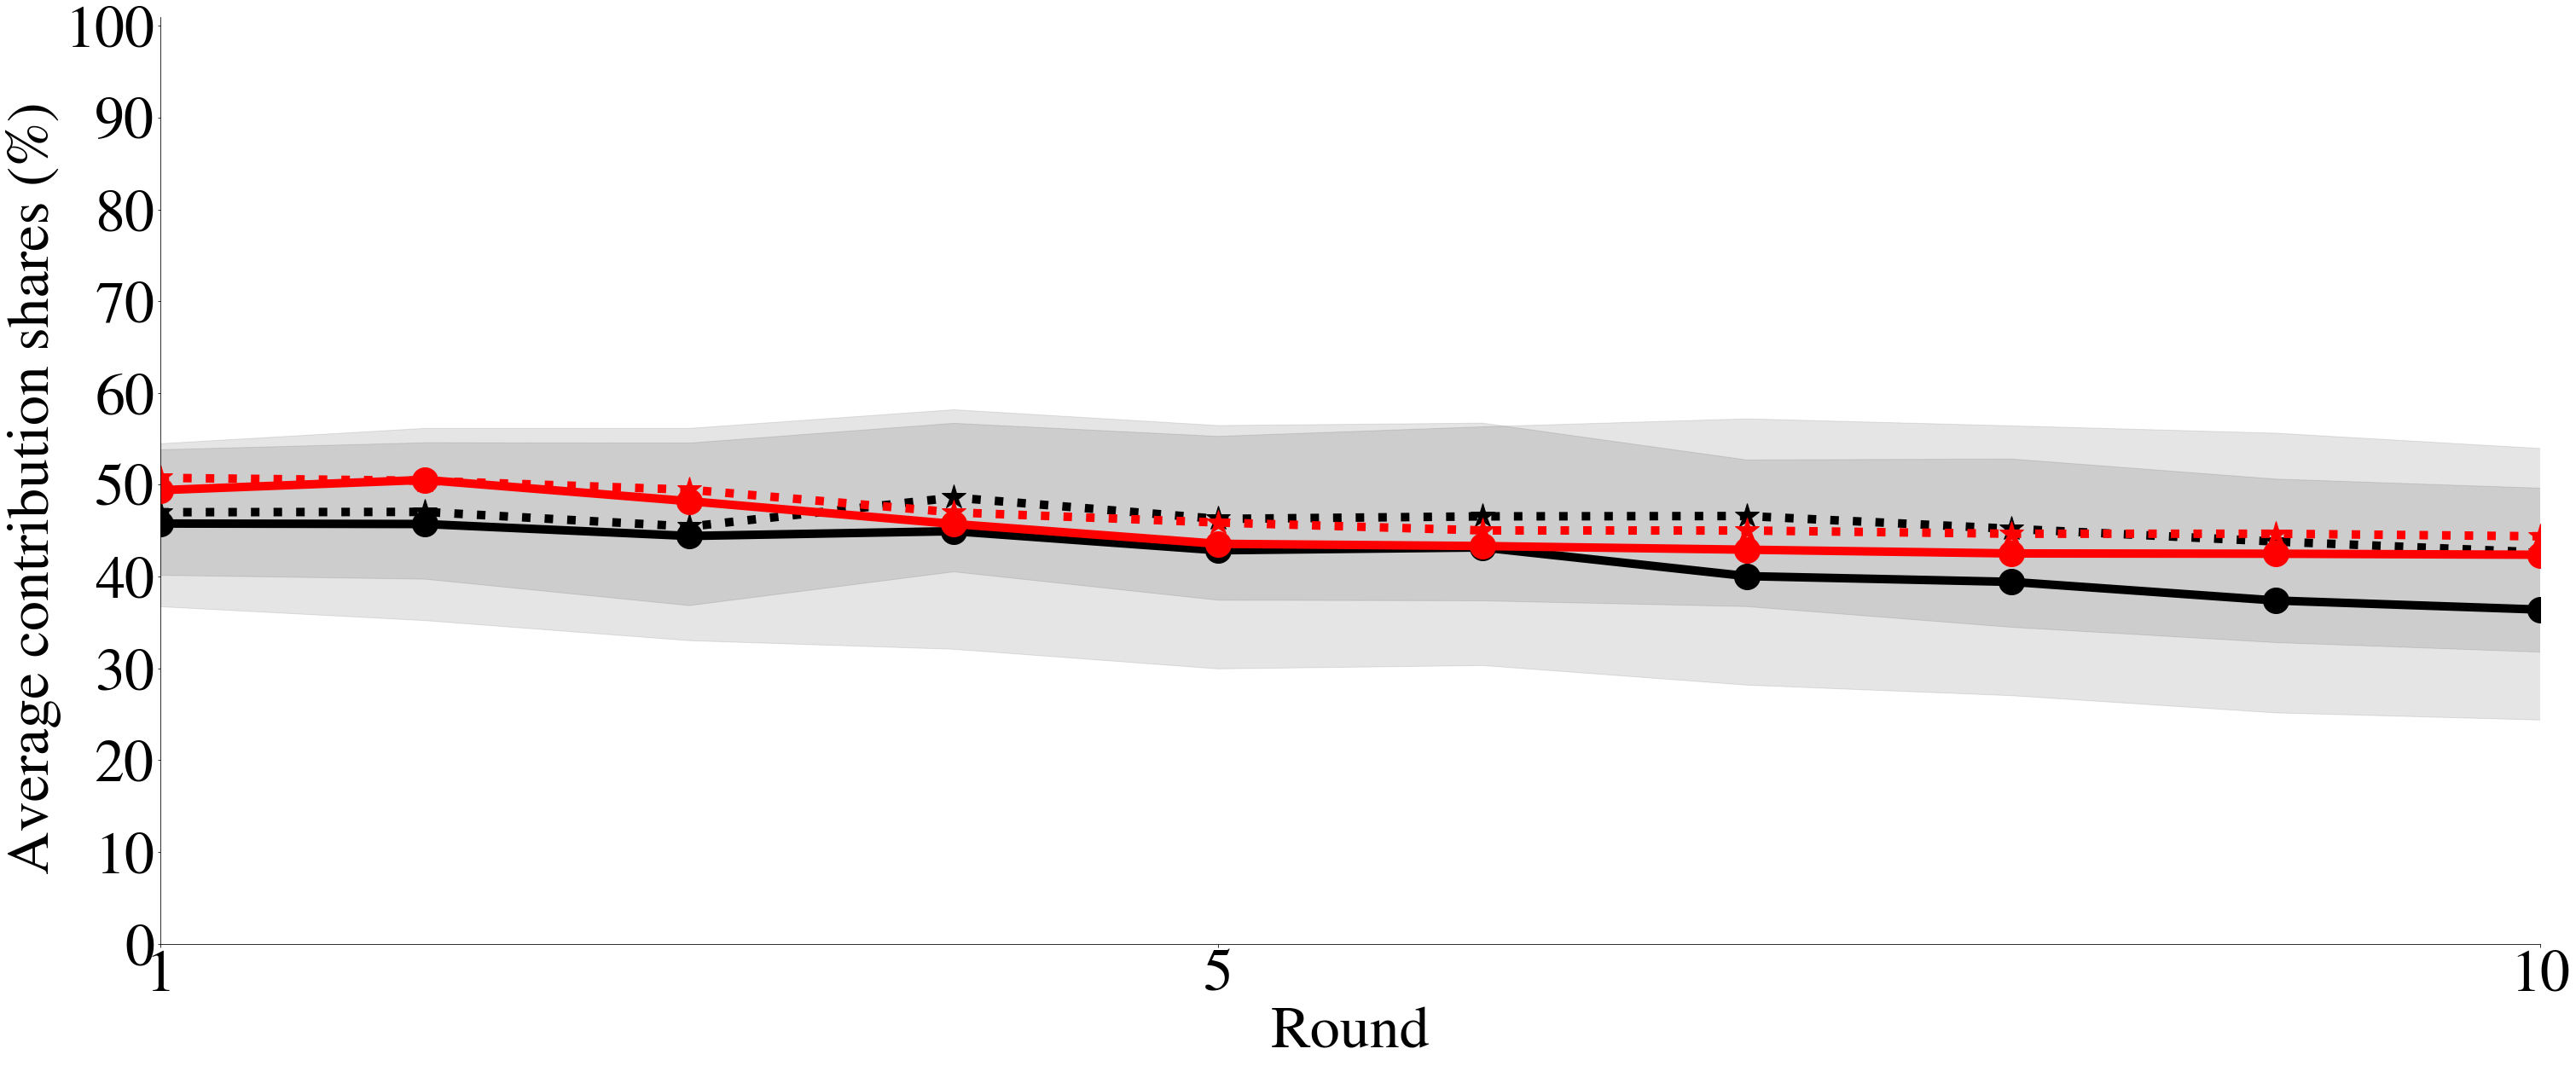

In [180]:
### Going back with only difference between Homogeneous and Heterogeneous

treatment_list = ['HETERO','HOMO']
treatment_var = 'Treatment'
var_of_interest =  'tot_cont_share'

LocalOnly = data_noOppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

output = CreateMean_CI_byHypothese(LocalOnly, var_of_interest,treatment_var,treatment_list , 20)

df = pd.DataFrame(output[0,:,:], columns = treatment_list)
df_ci_l = pd.DataFrame(output[1,:,:], columns = treatment_list)
df_ci_u = pd.DataFrame(output[2,:,:], columns = treatment_list)


pd.set_option('plotting.backend', 'matplotlib')

fig, ax = plt.subplots(figsize=(50, 20))

# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 101)
custom_ytick = np.arange(0, 101, step=10)
custom_xticklabel = [1, 5, 10, 15, 20]

plt.setp(ax, xticks=custom_xtick, xticklabels=custom_xticklabel, 
         yticks=custom_ytick, xlim=custom_xlim, ylim=custom_ylim)

treatment_marker = {'HETERO': '*',
                    'HOMO': 'o'
                   }
treatment_name = {'HETERO': 'Heterogeneous',
                    'HOMO': 'Homogeneous'}
custom_markercolor = ['black', 'black', 'black']
custom_markerfacecolor = ['black', 'black', 'black']
custom_markerfacecolor_s = ['white', 'white', 'red']
custom_linestyle = [':',  '-']

for j, yy in enumerate(treatment_list):
    ax.plot(df[yy], label=treatment_name[yy] + " (experiment)", marker=treatment_marker[yy], c=custom_markercolor[j], 
            ls=custom_linestyle[j], markerfacecolor=custom_markerfacecolor[j],
            linewidth=10, markersize=30)
    ax.fill_between(df_ci_u.index, df_ci_u[yy], df_ci_l[yy], alpha=0.1, color=custom_markercolor[j])
    # Simulations
    ax.plot(dfSim[yy], label=treatment_name[yy] + " (simulated)", marker=treatment_marker[yy], c='red', 
                         ls=custom_linestyle[j],markerfacecolor='red',
                         linewidth=10,  markersize=30 )

ax.set_xlabel('Round', fontsize=70)
ax.set_ylabel('Average contribution shares (%) ', fontsize=70)
# ax.set_title('Average Contribution Shares', fontsize=60)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', labelsize=70)
ax.tick_params(axis='y', labelsize=70)

# fig.legend(bbox_to_anchor=(.5, -0.1), loc="center", ncol=2, fontsize=70,
#            borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False)


fig.savefig(outputfigurel, bbox_inches="tight" )  

# plt.show()

# For simulation (Local + Global)

-Return : [Start Data Analysis](#Start-Data-Analysis)

In [181]:
data_Oppor = data_Oppor_allB
data_Oppor['End_level'] = "Homo (20)" 
data_Oppor.loc[data_Oppor['endowment']<=10,'End_level'] = "Low (10)"
data_Oppor.loc[data_Oppor['endowment']>20,'End_level'] = "High (30)"
data_Oppor['tot_cont_share'] = data_Oppor['tot_contr'] / data_Oppor['endowment'] * 100
data_Oppor['T_endw_comp']= data_Oppor['Treatment'] + ', ' + data_Oppor['End_level']
data_Oppor['local_share'] = data_Oppor['player.contribution_local']/ data_Oppor['endowment'] * 100
data_Oppor['global_share'] = data_Oppor['player.contribution_global']/ data_Oppor['endowment'] * 100
data_Oppor['Treatment_4']= 'Homogeneous\nLowC'
data_Oppor.loc[(data_Oppor['Treatment']=='HOMO') & (data_Oppor['FC']==80),'Treatment_4'] = "Homogeneous\nHighC"
data_Oppor.loc[(data_Oppor['Treatment']=='HETERO') & (data_Oppor['FC']==20),'Treatment_4'] = "Heterogeneous\nLowC"
data_Oppor.loc[(data_Oppor['Treatment']=='HETERO') & (data_Oppor['FC']==80),'Treatment_4'] = "Heterogeneous\nHighC"

In [182]:
data_OpporSim = CounterfactualData[CounterfactualData['Sequence']=='B1_bab']
data_OpporSim['End_level'] = "Homo (20)" 
data_OpporSim.loc[data_OpporSim['endowment']<=10,'End_level'] = "Low (10)"
data_OpporSim.loc[data_OpporSim['endowment']>20,'End_level'] = "High (30)"

data_OpporSim['tot_contr'] = data_OpporSim['player.contribution_local'] + np.nan_to_num(data_OpporSim['player.contribution_global'])
data_OpporSim['tot_cont_share'] = data_OpporSim['tot_contr'] / data_OpporSim['endowment'] * 100
data_OpporSim['T_endw_comp']= data_OpporSim['Treatment'] + ', ' + data_OpporSim['End_level']
data_OpporSim['local_share'] = data_OpporSim['player.contribution_local']/ data_OpporSim['endowment'] * 100
data_OpporSim['global_share'] = data_OpporSim['player.contribution_global']/ data_OpporSim['endowment'] * 100
data_OpporSim[ 'player.join_club'] = 1- np.isnan(data_OpporSim['player.contribution_global'])


data_OpporSim['Treatment_4']= 'Homogeneous\nLowC'
data_OpporSim.loc[(data_OpporSim['Treatment']=='HOMO') & (data_OpporSim['FC']==80),'Treatment_4'] = "Homogeneous\nHighC"
data_OpporSim.loc[(data_OpporSim['Treatment']=='HETERO') & (data_OpporSim['FC']==20),'Treatment_4'] = "Heterogeneous\nLowC"
data_OpporSim.loc[(data_OpporSim['Treatment']=='HETERO') & (data_OpporSim['FC']==80),'Treatment_4'] = "Heterogeneous\nHighC"

C:\Users\xinxi\AppData\Local\Temp/ipykernel_10068/3308293792.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_OpporSim['End_level'] = "Homo (20)"
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\xinxi\AppData\Local\Temp/ipykernel_10068/3308293792.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

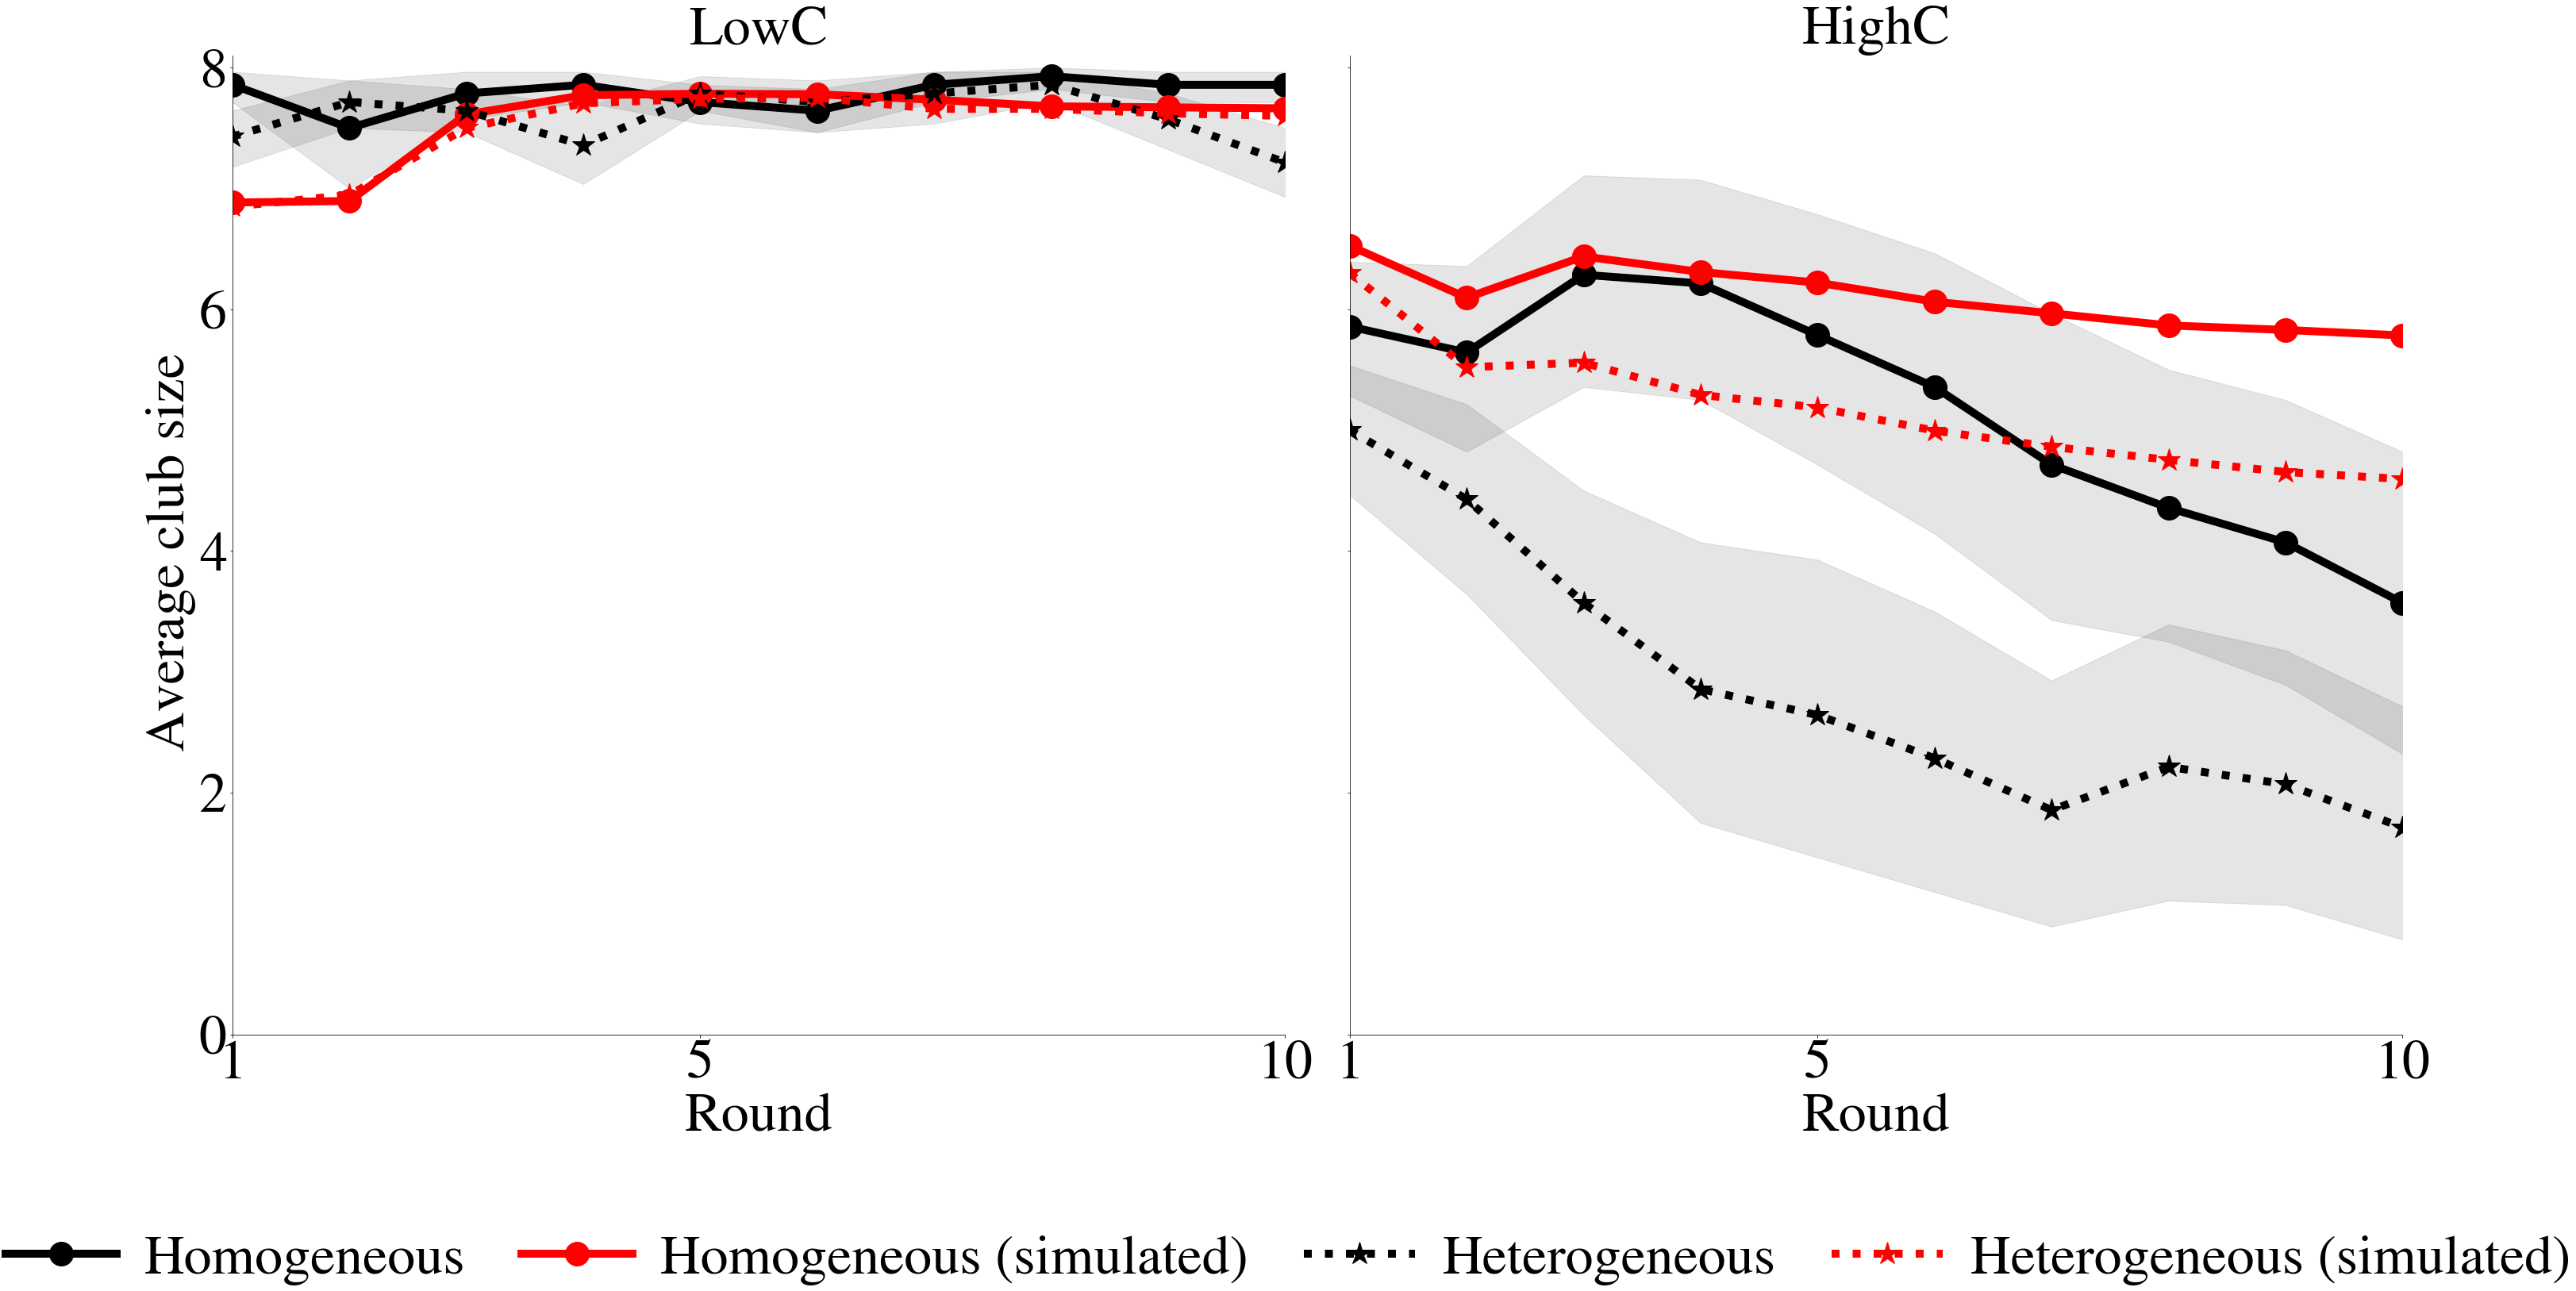

In [183]:
### This is to create the graph for all rounds (colored)
data_Oppor=data_Oppor_allB

treatment_list = ['HOMO', 'HETERO']
treatment_var = 'Treatment'
var_of_interest =  'ClubSize'
GroupedData = data_Oppor.groupby([ 
                      treatment_var,
    'player.local_community',  'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

# Left graph for FC=2
output = CreateMean_CI_byHypothese(GroupedData[GroupedData['FC']==20], 
                                   var_of_interest,treatment_var,treatment_list , 20)

df_LGs1 = pd.DataFrame(output[0,:,:], columns = treatment_list)
df_LGs1_ci_l = pd.DataFrame(output[1,:,:], columns = treatment_list)
df_LGs1_ci_u = pd.DataFrame(output[2,:,:], columns = treatment_list)

# right graph for absolute value 

output = CreateMean_CI_byHypothese(GroupedData[GroupedData['FC']==80], var_of_interest,treatment_var,treatment_list , 20)

df_LGs1_r = pd.DataFrame(output[0,:,:], columns = treatment_list)
df_LGs1_ci_lr = pd.DataFrame(output[1,:,:], columns = treatment_list)
df_LGs1_ci_ur = pd.DataFrame(output[2,:,:], columns = treatment_list)


 # Join Behavior
treatment_list = ['HOMO', 'HETERO']
treatment_var = 'Treatment'
var_of_interest =  'player.join_club'
LocalOnly = data_OpporSim.groupby([ 
                      treatment_var,
    'player.local_community',   'session.code',
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].mean().reset_index()

# Left graph for FC=2
output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==20], 
                                   var_of_interest,treatment_var,treatment_list , 20)*8

df_LGs1Simj = pd.DataFrame(output[0,:,:], columns = treatment_list)
df_LGs1_ci_lSimj = pd.DataFrame(output[1,:,:], columns = treatment_list)
df_LGs1_ci_uSimj = pd.DataFrame(output[2,:,:], columns = treatment_list)

# right graph for absolute value 

output = CreateMean_CI_byHypothese(LocalOnly[LocalOnly['FC']==80], var_of_interest,treatment_var,treatment_list , 20)*8

df_LGs1_rSimj = pd.DataFrame(output[0,:,:], columns = treatment_list)
df_LGs1_ci_lrSimj = pd.DataFrame(output[1,:,:], columns = treatment_list)
df_LGs1_ci_urSimj = pd.DataFrame(output[2,:,:], columns = treatment_list)


pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=1, ncols=2,  sharex=True,  sharey=True,  
                         constrained_layout=True, figsize=(40, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Left figure
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 8.1)
custom_xtick = np.array([0,4,9,14,19])
custom_ytick = np.arange(0,8.1,step=2)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

custom_marker = [ 'o', '*', 'o', '*']
    
custom_markercolor = ['black','black', 'black', ]
custom_markerfacecolor = ['white', 'white','black']
custom_linestyle = ['-', ':']
labels =  ['Homogeneous\nLowC', 'Heterogeneous\nLowC', 'Homogeneous\nHighC', 'Heterogeneous\nHighC']
labels2 =  ['Homogeneous', 'Heterogeneous', 'Homogeneous', 'Heterogeneous']

for j, yy in enumerate(treatment_list):
    
    axes[0].plot(df_LGs1[yy], label=labels2[j], marker=custom_marker[j], c='black', 
                         ls=custom_linestyle[j],markerfacecolor='black',
                         linewidth=10,  markersize=30 )
    axes[0].fill_between(df_LGs1_ci_u.index, df_LGs1_ci_u[yy],df_LGs1_ci_l[yy], alpha=0.1, color='black')
    # Simulation 
    axes[0].plot(df_LGs1Simj[yy], label=labels2[j+2]+' (simulated)', marker=custom_marker[j], c='red', 
                         ls=custom_linestyle[j],markerfacecolor='red',
                         linewidth=10,  markersize=30 )

    
axes[0].set_xlabel('Round', fontsize=70)
axes[1].set_xlabel('Round', fontsize=70)
axes[0].set_ylabel('Average club size ', fontsize=70)
axes[0].set_title('LowC', fontsize=70)


# Right figure
# Defining custom 'xlim' and 'ylim' values.
plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)


for j, yy in enumerate(treatment_list):
    axes[1].plot(df_LGs1_r[yy], label=labels2[j+2], marker=custom_marker[j], c='black', 
                         ls=custom_linestyle[j],markerfacecolor='black',
                         linewidth=10,  markersize=30 )
    axes[1].fill_between(df_LGs1_ci_ur.index, df_LGs1_ci_ur[yy],df_LGs1_ci_lr[yy], alpha=0.1, color='black')
    # Simulation 
    axes[1].plot(df_LGs1_rSimj[yy], label=labels2[j+2], marker=custom_marker[j], c='red', 
                         ls=custom_linestyle[j],markerfacecolor='red',
                         linewidth=10,  markersize=30 )

axes[1].set_title('HighC', fontsize=70)

for i in range(2):
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)  
    axes[i].tick_params(axis='x', labelsize=70)
    axes[i].tick_params(axis='y', labelsize=70)

handles, labels = axes[0].get_legend_handles_labels() 

fig.legend(handles, labels , bbox_to_anchor=(.5,-.1), loc="center" , ncol=6 , fontsize=70,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
# fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Global-Join.pdf_LGs1', bbox_inches="tight" )  

fig.savefig(outputfigure1, bbox_inches="tight" )  


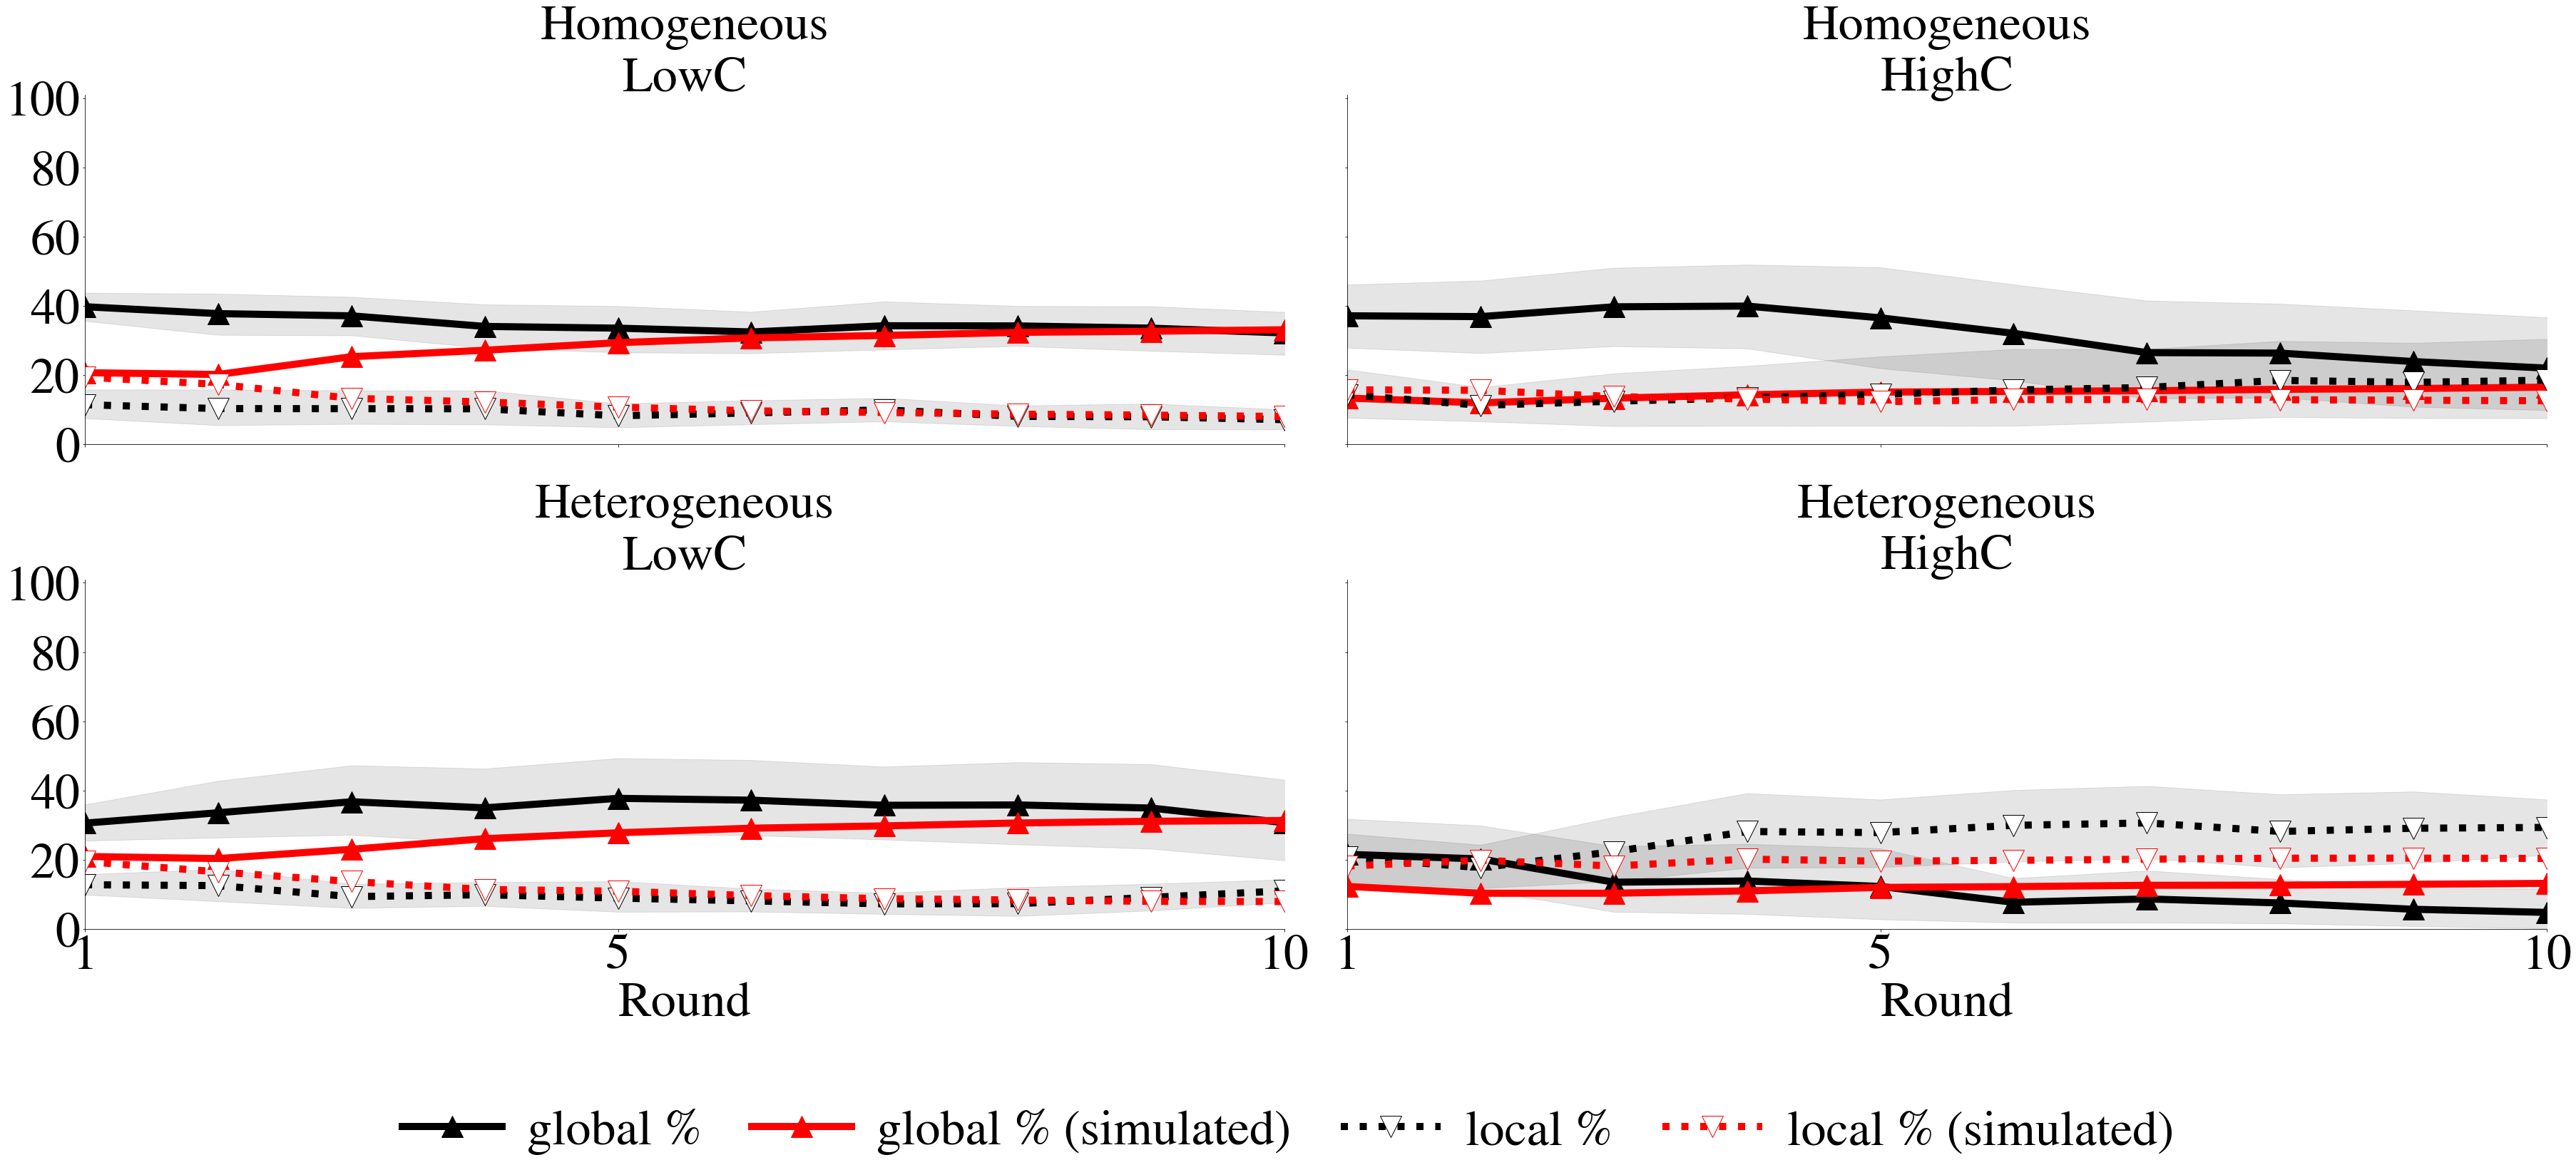

In [184]:
### For L/G, share split for all groups
data_Oppor=data_Oppor_allB

# bottom graph for contribution splits 
treatment_list_r = ['Homogeneous\nLowC', 'Heterogeneous\nLowC', 'Homogeneous\nHighC', 'Heterogeneous\nHighC']
treatment_var = 'Treatment_4'
var_l = 'player.contribution_local'
var_g = 'player.contribution_global'
var_of_interest =  [var_l, var_g, 'tot_contr', 'endowment']

LG = data_Oppor.groupby([ 
                      treatment_var, 'group.id_in_subsession','session.code',
#     'player.local_community',  
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()

LG['local_share'] = LG[var_l] / LG['endowment'] * 100
LG['global_share'] = LG[var_g] / LG['endowment'] * 100
output  = CreateMean_CI_byHypothese(LG, 'local_share',treatment_var,treatment_list_r , 20)
df_local = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_l_local = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_u_local = pd.DataFrame(output[2,:,:], columns = treatment_list_r)
output  = CreateMean_CI_byHypothese(LG, 'global_share',treatment_var,treatment_list_r , 20)
df_global = pd.DataFrame(output[0,:,:], columns = treatment_list_r)
df_ci_l_global = pd.DataFrame(output[1,:,:], columns = treatment_list_r)
df_ci_u_global = pd.DataFrame(output[2,:,:], columns = treatment_list_r)


# Simulation part
LG = data_OpporSim.groupby([ 
                      treatment_var, 'session.code','player.local_community',
#     ,  'group.id_in_subsession'
                      'FC','Sequence','subsession.round_number', 'subsession.period'])[var_of_interest].sum().reset_index()

LG['local_share'] = LG[var_l] / LG['endowment'] * 100
LG['global_share'] = LG[var_g] / LG['endowment'] * 100
output_siml  = CreateMean_CI_byHypothese(LG, 'local_share',treatment_var,treatment_list_r , 20)
df_local_sim = pd.DataFrame(output_siml[0,:,:], columns = treatment_list_r)

output_simg  = CreateMean_CI_byHypothese(LG, 'global_share',treatment_var,treatment_list_r , 20)
df_global_sim = pd.DataFrame(output_simg[0,:,:], columns = treatment_list_r)



pd.set_option('plotting.backend', 'matplotlib')



fig, axes = plt.subplots(nrows=2, ncols=2,  sharex=True,  sharey=True,  
                         constrained_layout=True, figsize=(50, 20))
fig.set_constrained_layout_pads( w_pad=1 / 100)

# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (0, 9)
custom_ylim = (0, 101)
custom_xtick = np.array([0,4,9,14,19])
custom_ytick = np.arange(0,101,step=20)
custom_xticklabel = [1,5,10,15,20]

plt.setp(axes[0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

plt.setp(axes[1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
     yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

custom_marker = ['o','*', 'o', '*', '*', '*']

custom_markercolor = [0,2,8,10 ]
custom_markerfacecolor = ['white', 'black','white', 'black']
custom_linestyle = ['-',':','-',':',]

axes[1,1].set_xlabel('Round', fontsize=70)
axes[1,0].set_xlabel('Round', fontsize=70)

for j, yy in enumerate(treatment_list_r):
    i = j // 2
    ii = j % 2
    axes[ii,i].plot(df_global[yy], label='global %', marker='^', c='black', 
                         ls='-',markerfacecolor='black',
                         linewidth=10,  markersize=30 )
    axes[ii,i].fill_between(df_ci_u_global.index, df_ci_u_global[yy],df_ci_l_global[yy], alpha=0.1, 
                           color='black')
    axes[ii,i].set_title(yy, fontsize=70)
    
    #Simulation part
    axes[ii,i].plot(df_global_sim[yy], label='global % (simulated)', marker='^', c='red', 
                         ls='-',markerfacecolor='red',
                         linewidth=10,  markersize=30 )
    
    axes[ii,i].plot(df_local[yy], label='local %', marker='v', c='black', 
                         ls=':',markerfacecolor='white',
                         linewidth=10,  markersize=30 )
    axes[ii,i].fill_between(df_ci_u_local.index, df_ci_u_local[yy],df_ci_l_local[yy], alpha=0.1, 
                           color='black')
    
    #Simulation part
    axes[ii,i].plot(df_local_sim[yy], label='local % (simulated)',  marker='v', c='red', 
                         ls=':',markerfacecolor='white',
                         linewidth=10,  markersize=30 )

    
#     axes[ii,i].set_title(yy, fontsize=60)
hh = []
ll = []
for i in range(2):
    for j in range(2):
        axes[i,j].spines['top'].set_visible(False)
        axes[i,j].spines['right'].set_visible(False)  
        axes[i,j].tick_params(axis='x', labelsize=70)
        axes[i,j].tick_params(axis='y', labelsize=70)
        h, l = axes[i,j].get_legend_handles_labels()
        hh +=h
        ll +=l


# ph = [plt.plot([], marker="", ls="")[0]] * 2
# handles = ph + hh
# labels = ["Global:\n ","Local:\n "] + ll


handles, labels = axes[0,0].get_legend_handles_labels() 

fig.legend(handles, labels,bbox_to_anchor=(.5,-.1), loc="center" , ncol=5 , fontsize=70,
               borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)
# fig.savefig('..\\Output\\01-group-data-Dec-2022-Local-Global-Contribution-Tradeoff.pdf', bbox_inches="tight" )  
fig.savefig(outputfigure2, bbox_inches="tight" )  


In [185]:
# # Try to conbine all graphs into a 2X4 pannel


# ### Compare with Simulation results

# pd.set_option('plotting.backend', 'matplotlib')

# fig, axes = plt.subplots(nrows=4, ncols=2,  sharex=True,  
#                          constrained_layout=True, figsize=(60, 30))
# fig.set_constrained_layout_pads( w_pad=1 / 100)

# ##### Local only 
# custom_xlim = (0, 9)
# custom_ylim = (0, 101)
# custom_xtick = np.array([0,4,9,14,19])
# custom_ytick = np.arange(0,101,step=50)
# custom_xticklabel = [1,5,10,15,20]
 
# plt.setp(axes[0,0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
#      yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# plt.setp(axes[0,1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
#      yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','*', 'o', '*', '*', '*']

# custom_markercolor = [0,2,8,10 ]
# custom_markerfacecolor = ['white', 'black','white', 'black']
# custom_linestyle = ['-',':','-',':',]

# for j, yy in enumerate(treatment_list_r):
#     i = j // 2
# #     palette_tab20[custom_markercolor[j]]
#     axes[0,i].plot(df_r[yy], label=yy, marker=custom_marker[j], c=palette_tab20[custom_markercolor[j]], 
#                          ls=custom_linestyle[j],markerfacecolor=palette_tab20[custom_markercolor[j]],
#                          linewidth=10,  markersize=30 )
#     axes[0,i].fill_between(df_ci_ur.index, df_ci_ur[yy],df_ci_lr[yy], alpha=0.1, color=palette_tab20[custom_markercolor[j]])
#     # Simulations
#     axes[0,i].plot(df_rSim[yy],  marker=custom_marker[j], c='red', 
#                          ls=custom_linestyle[j],markerfacecolor='red',
#                          linewidth=10,  markersize=30 )

# axes[0,0].set_ylabel('Shares (%) ', fontsize=70)
# axes[0,0].set_title('LowC\nL: Contribution ', fontsize=70)
# axes[0,1].set_title('HighC\nL: Contribution ', fontsize=70)


# ##### LG Stage 1
# custom_xlim = (0, 9)
# custom_ylim = (0, 1.1)
# custom_ytick = np.arange(0,1.1,step=.5)
# custom_xticklabel = [1,5,10,15,20]

# plt.setp(axes[1,0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
#      yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# custom_marker = ['o','*', 'o', '*', '*', '*']
    
# custom_markercolor = ['black','black', 'black', ]
# custom_markerfacecolor = ['white', 'white','black']
# custom_linestyle = ['-',':']
# labels =  ['Homogeneous\nLowC', 'Heterogeneous\nLowC', 'Homogeneous\nHighC', 'Heterogeneous\nHighC']

# for j, yy in enumerate(treatment_list):
    
#     axes[1,0].plot(df_LGs1[yy], label=labels[j], marker=custom_marker[j], c=palette_tab20[2*j], 
#                          ls=custom_linestyle[j],markerfacecolor=palette_tab20[2*j],
#                          linewidth=10,  markersize=30 )
#     axes[1,0].fill_between(df_LGs1_ci_u.index, df_LGs1_ci_u[yy],df_LGs1_ci_l[yy], alpha=0.1, color=palette_tab20[2*j])
#     # Simulation 
#     axes[1,0].plot(df_LGs1Simj[yy],  marker=custom_marker[j], c='red', 
#                          ls=custom_linestyle[j],markerfacecolor='red',
#                          linewidth=10,  markersize=30 )


# axes[1,0].set_ylabel('Proportion', fontsize=70)
# axes[1,0].set_title('LG: Join', fontsize=70)


# # Right figure
# # Defining custom 'xlim' and 'ylim' values.
# plt.setp(axes[1,1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
#      yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)


# for j, yy in enumerate(treatment_list):
#     axes[1,1].plot(df_LGs1_r[yy], label=labels[j+2], marker=custom_marker[j], c=palette_tab20[8+2*j], 
#                          ls=custom_linestyle[j],markerfacecolor=palette_tab20[8+2*j],
#                          linewidth=10,  markersize=30 )
#     axes[1,1].fill_between(df_LGs1_ci_ur.index, df_LGs1_ci_ur[yy],df_LGs1_ci_lr[yy], alpha=0.1, color=palette_tab20[8+2*j])
#     # Simulation 
#     axes[1,1].plot(df_LGs1_rSimj[yy],  marker=custom_marker[j], c='red', 
#                          ls=custom_linestyle[j],markerfacecolor='red',
#                          linewidth=10,  markersize=30 )

# axes[1,1].set_title('LG: Join', fontsize=70)

# ######### LG: contribution 
# # Defining custom 'xlim' and 'ylim' values.
# custom_xlim = (0, 9)
# custom_ylim = (0, 101)
# custom_xtick = np.array([0,4,9,14,19])
# custom_ytick = np.arange(0,101,step=50)
# custom_xticklabel = [1,5,10,15,20]

# plt.setp(axes[2,0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
#      yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# plt.setp(axes[2,1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
#      yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# plt.setp(axes[3,0], xticks=custom_xtick, xticklabels=custom_xticklabel, 
#      yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)

# plt.setp(axes[3,1], xticks=custom_xtick, xticklabels=custom_xticklabel, 
#      yticks= custom_ytick,xlim=custom_xlim, ylim=custom_ylim)


# custom_marker = ['o','*', 'o', '*']

# custom_markercolor = [0,2,8,10 ]
# custom_markerfacecolor = ['white', 'black','white', 'black']
# custom_linestyle = ['(0, (5, 10)))',' (0, (1, 10)))','(0, (5, 10)))',' (0, (1, 10)))']



# for j, yy in enumerate(treatment_list_r):
#     i = j // 2 
#     ii = j % 2 + 2
#     axes[ii,i].plot(df_global[yy], label=yy, marker='^', c=palette_tab20[custom_markercolor[j]], 
#                          ls='-',markerfacecolor=palette_tab20[custom_markercolor[j]],
#                          linewidth=5,  markersize=30 )
#     axes[ii,i].fill_between(df_ci_u_global.index, df_ci_u_global[yy],df_ci_l_global[yy], alpha=0.1, 
#                            color=palette_tab20[custom_markercolor[j]])
    
#     #Simulation part
#     axes[ii,i].plot(df_global_sim[yy], marker='^', c='red', 
#                          ls='-',markerfacecolor='red',
#                          linewidth=5,  markersize=30 )
    
#     axes[ii,i].plot(df_local[yy], label=yy, marker='v', c=palette_tab20[custom_markercolor[j]], 
#                          ls=':',markerfacecolor=palette_tab20[custom_markercolor[j]],
#                          linewidth=5,  markersize=30 )
#     axes[ii,i].fill_between(df_ci_u_local.index, df_ci_u_local[yy],df_ci_l_local[yy], alpha=0.1, 
#                            color=palette_tab20[custom_markercolor[j]])
    
#     #Simulation part
#     axes[ii,i].plot(df_local_sim[yy],  marker='v', c='red', 
#                          ls=':',markerfacecolor='red',
#                          linewidth=5,  markersize=30 )

# axes[3,1].set_xlabel('Round', fontsize=70)
# axes[3,0].set_xlabel('Round', fontsize=70)
# axes[2,0].set_title('LG: Contribution', fontsize=70)
# axes[2,1].set_title('LG: Contribution', fontsize=70)
# axes[2,0].set_ylabel('Shares (%)', fontsize=70)
# axes[3,0].set_ylabel('Shares (%)', fontsize=70)



# hh = []
# ll = []
# for i in range(2,4):
#     for j in range(2):
#         h, l = axes[i,j].get_legend_handles_labels()
#         hh +=h
#         ll +=l

# ph = [plt.plot([], marker="", ls="")[0]] * 2

# handles = ph + hh

# labels = [ "Global:\n ","Local:\n "] + ll


# fig.legend(handles, labels,bbox_to_anchor=(.5,-.1), loc="center" , ncol=5 , fontsize=70,
#                borderpad=0, columnspacing=1, labelspacing=.5, handletextpad=.5, frameon=False,)

# for i in range(4):
#     for j in range(2):
#         axes[i,j].spines['top'].set_visible(False)
#         axes[i,j].spines['right'].set_visible(False)  
#         axes[i,j].tick_params(axis='x', labelsize=70)
#         axes[i,j].tick_params(axis='y', labelsize=70)


# # fig.savefig('..\\Output\\06-group-data-Dec-2022-Add-Simulation-All.pdf', bbox_inches="tight" )  
# # fig.savefig('..\\Output\\06-group-data-Dec-2022-Add-Simulation-Sensitivity-AllSelfish.pdf', bbox_inches="tight" )  
# # fig.savefig(outputfigure, bbox_inches="tight" )  

